In [449]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import pyreadr
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros
from tensorflow.keras.optimizers.legacy import Adam, Nadam # the non-legacy version runs slowly on Mac
import keras_tuner as kt
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

#-------------------------- import data --------------------------
'''we use the popular French Motor TPL insurance claim data '''
r_data = pyreadr.read_r("data/freMPL1.rda")
data = r_data['freMPL1']

# set column to the right category
data['HasKmLimit'] = data['HasKmLimit'].astype('category')

In [450]:
############################ 1. PREPROCESSING ############################

#-------------------------- filter claim data --------------------------

# drop unnecessary columns and filter policies with positive claims
claim = data[data["ClaimInd"] == 1].drop(columns = ["RecordBeg", "RecordEnd", "ClaimInd"]).reset_index(drop = True)
claim.head()

# global variables
cont_vars = ["LicAge", "DrivAge", "BonusMalus"] # continuous variables
ordinal_vars = ["RiskVar", "VehAge", "VehPrice", "VehMaxSpeed"] # ordinal categorical variables
nominal_vars = [] # nominal categorical variables
for var in claim.columns:
    if var not in cont_vars + ["Exposure", "ClaimAmount"] + ordinal_vars:
        nominal_vars.append(var)
cat_vars = nominal_vars + ordinal_vars


# #-------------------------- cap outliers for ClaimAmount --------------------------
log_claim = np.log(claim['ClaimAmount'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# apply caps
claim['ClaimAmount'] = np.exp(np.where(log_claim < lower_whisker, lower_whisker, log_claim))
claim['ClaimAmount'] = np.exp(np.where(log_claim > upper_whisker, upper_whisker, np.log(claim['ClaimAmount'])))


# -------------------------- remove outliers for BonusMalus --------------------------
claim["BonusMalus"] = np.where(claim["BonusMalus"] > 150, 150, claim["BonusMalus"])
claim["BonusMalus"] = np.where(claim["BonusMalus"] > 150, 150, claim["BonusMalus"])

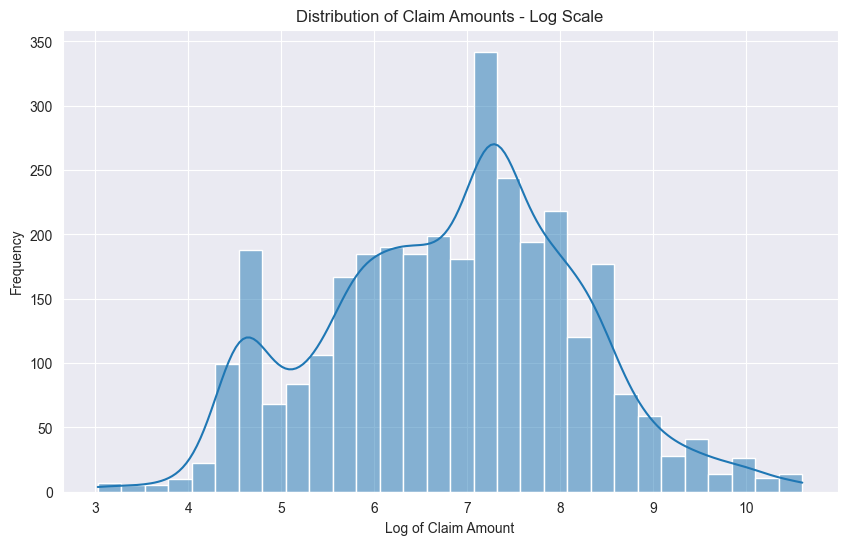

In [451]:
#-------------------------- distribution of log claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(claim['ClaimAmount']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of Claim Amounts - Log Scale')
plt.xlabel('Log of Claim Amount')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [452]:
#-------------------------- group rare categories --------------------------

threshold = 10 # categories with fewer than 10 observations will be grouped

### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

''' for SocioCateg, group rare categories into 1 category called Other'''
socio_summary = claim["SocioCateg"].value_counts()
categories_to_replace = socio_summary[socio_summary <= threshold].index # select the categories with 10 or fewer observations
claim["SocioCateg"] = claim["SocioCateg"].replace(categories_to_replace, 'Other')


''' for VehPrice, we need to make sure that the ordinal nature is retained.
W, X, Y, Z will be grouped into "W" group and B will be grouped with A to create 
an "AB" class.'''
claim["VehPrice"] = claim["VehPrice"].replace(['X', 'Y', 'Z'], 'W')
claim["VehPrice"] = claim["VehPrice"].replace(['A', 'B'], 'AB')


'''for VehEnergy and VehEngine, we remove 'electric' class'''
claim = claim[claim['VehEngine'] != 'electric'].reset_index(drop = True)

# remove unused categories
for var in nominal_vars:
    claim[var] = claim[var].cat.remove_unused_categories()

# check the number of distinct values after grouping
print(claim.shape)
print(get_summary(claim, "SocioCateg"))
print(get_summary(claim, "VehPrice"))
print(get_summary(claim, "VehEngine"))
print(get_summary(claim, "VehEnergy"))

(3264, 19)
   SocioCateg  Count
0       CSP50   1850
1       CSP60    409
2       CSP55    262
3        CSP1    196
4       CSP26     96
5       CSP66     93
6       CSP48     88
7       CSP42     80
8       CSP46     70
9       CSP37     44
10      Other     33
11      CSP49     30
12       CSP6     13
   VehPrice  Count
0         K    328
1         L    306
2         J    305
3         G    262
4         I    244
5         H    238
6         F    237
7         E    236
8         M    202
9         N    184
10        O    150
11        D    147
12        P    121
13        Q     88
14        R     64
15        C     39
16        S     29
17        U     22
18       AB     18
19        W     18
20        V     15
21        T     11
                      VehEngine  Count
0                     injection   2187
1  direct injection overpowered    830
2         injection overpowered    219
3                   carburation     28
  VehEnergy  Count
0   regular   2154
1    diesel   1110


/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_29779/3082177258.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  claim["SocioCateg"] = claim["SocioCateg"].replace(categories_to_replace, 'Other')
/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_29779/3082177258.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  claim["VehPrice"] = claim["VehPrice"].replace(['X', 'Y', 'Z'], 'W')
/var/folders/30/wpb2n_hs72q5fz9yvp8c1cth0000gv/T/ipykernel_29779/3082177258.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with Cate

In [453]:
#-------------------------- encode ordinal categorical variables --------------------------

# define the order for VehAge
vehage_order = ['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+']

# apply encoding for vehicle age
oe_vehage = OrdinalEncoder(categories = [vehage_order])
oe_vehage.fit(claim[["VehAge"]])

# apply encoding for VehPrice and VehMaxSpeed
oe_ordinal = OrdinalEncoder()
oe_ordinal.fit(claim[["VehPrice", "VehMaxSpeed"]])

# check the output
print(oe_vehage.categories_)
print(oe_ordinal.categories_)

[array(['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+'], dtype=object)]
[array(['AB', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W'], dtype=object), array(['1-130 km/h', '130-140 km/h', '140-150 km/h', '150-160 km/h',
       '160-170 km/h', '170-180 km/h', '180-190 km/h', '190-200 km/h',
       '200-220 km/h', '220+ km/h'], dtype=object)]


In [454]:
# -------------------------- apply the encoding directly into the data --------------------------

# get the ordinal values
vehage = oe_vehage.transform(claim[["VehAge"]])
ord_var = oe_ordinal.transform(claim[["VehPrice", "VehMaxSpeed"]])

# convert into dataframe
vehage_df = pd.DataFrame(vehage, columns = ["VehAge"])
ord_df = pd.DataFrame(ord_var, columns = ["VehPrice", "VehMaxSpeed"])

# replace relevant columns
claim["VehAge"] = vehage_df
claim[["VehPrice", "VehMaxSpeed"]] = ord_df

# check
claim.head()

,Exposure,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage
0,0.500,224,3.0,Male,Other,Other,Professional,53,0,72,van,10.0,direct injection overpowered,diesel,2.0,0,1418.610272,19,None
1,0.218,169,6.0,Male,Other,CSP50,Private+trip to office,32,0,50,sedan,5.0,injection,diesel,4.0,B,146.255891,19,None
2,0.882,378,1.0,Female,Other,CSP60,Private,58,0,50,sedan,8.0,injection,regular,5.0,M1,102.590030,17,None
3,1.000,454,0.0,Male,Other,CSP50,Professional,56,0,50,sport utility vehicle,14.0,direct injection overpowered,diesel,8.0,M2,1562.356495,17,Private garage
4,0.097,446,0.0,Male,Alone,CSP48,Professional,57,0,50,sedan,9.0,direct injection overpowered,diesel,6.0,M1,2020.635952,18,None


In [455]:
############################ 2. NEURAL ADDITIVE MODEL - FULL IMPLEMENTATION ############################

# -------------------------- data preparation --------------------------
'''we first fit a NAM with shallow subnets considering only main effects to select the most important variables'''
embedding_vars = ["SocioCateg", "VehBody", "VehClass", "VehUsage", "VehEngine"] # categorical variables with many levels that require embedding
binary_vars = [var for var in nominal_vars if var not in embedding_vars] # binary variables

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    claim.drop(["ClaimAmount"], axis = 1), claim[["ClaimAmount"]], test_size = 0.2, random_state = 1)


# -------------------------- apply encoding --------------------------

# define transformer - StandardScaler will be applied to all numeric and ordinal categorical variables
ct_NAM = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), embedding_vars + binary_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit the transformer to the data
train = ct_NAM.fit_transform(X_train)
test = ct_NAM.transform(X_test)
feature_names = ct_NAM.get_feature_names_out()  # get the columns' names
print(feature_names)

['Exposure' 'SocioCateg' 'VehBody' 'VehClass' 'VehUsage' 'VehEngine'
 'Gender' 'MariStat' 'HasKmLimit' 'VehEnergy' 'Garage' 'LicAge' 'VehAge'
 'DrivAge' 'BonusMalus' 'VehPrice' 'VehMaxSpeed' 'RiskVar']


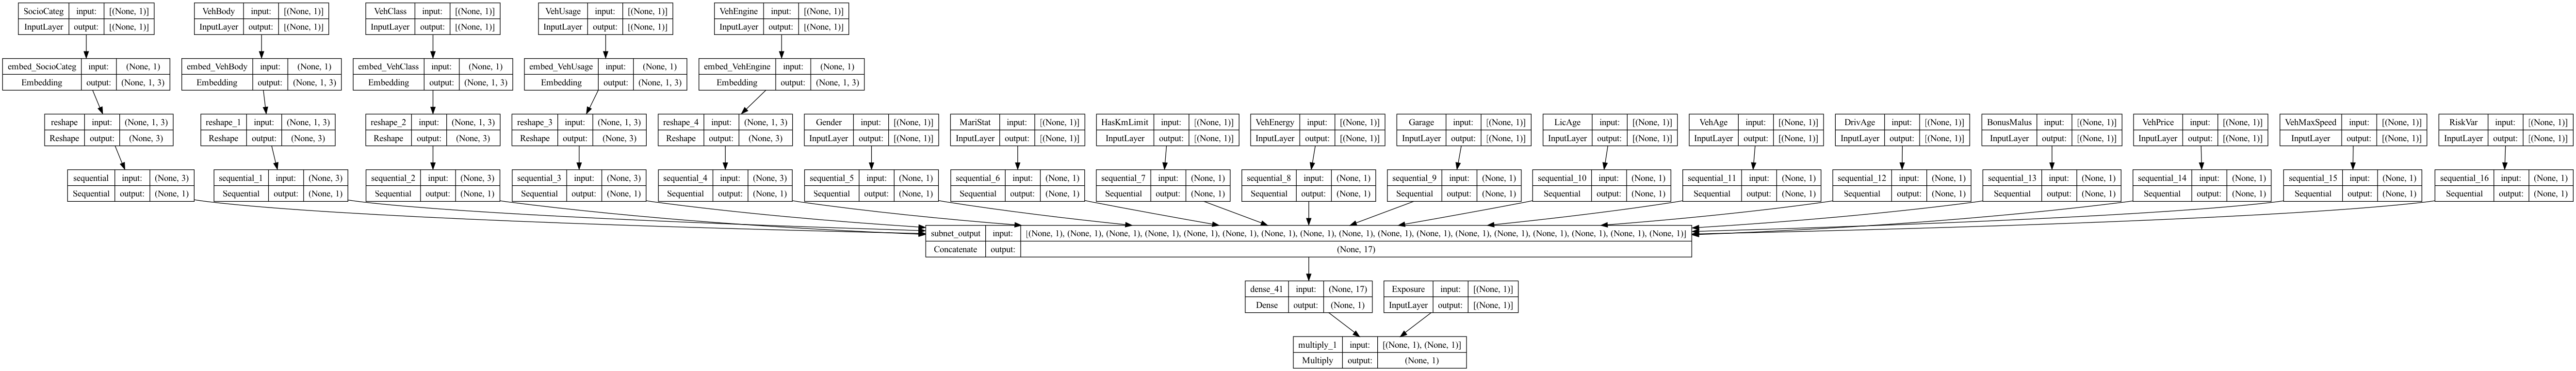

In [456]:
# -------------------------- define a function to fit a model --------------------------

# for reproducibility
seed_value = 2809
keras.utils.set_random_seed(seed_value)

'''function to create a subnetwork'''
def create_subnet(num_layers, units_per_layer, activation, dropout_rate = 0):
    """create a subnet with configurable layers and neurons."""
    model = Sequential()
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation))
        model.add(Dropout(dropout_rate, seed = 1))
    model.add(Dense(1))
    model.add(BatchNormalization())  # normalize the output to ensure identifiability
    return model


'''model architecture'''
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 10
num_layers = 1
activation = 'leaky_relu'
embedding_dim = 3

# main effect
for name in feature_names:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)
    
    if name == "Exposure":  # Direct use without a subnet
        exposure_input = input_layer
    elif name in embedding_vars:
        # categorical variables will pass through an embedding layer
        embed_layer = Embedding(input_dim = claim[name].nunique(), 
                    output_dim = embedding_dim,
                    name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
        subnet = create_subnet(num_layers, num_neurons, activation)
        sub_output = subnet(embed_layer_reshape)
        sub_outputs.append(sub_output)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation)
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = "exponential")(subnets)

# multiply output with exposure
final_output = Multiply()([exposure_input, output_layer])
model_main = Model(inputs = inputs, outputs = final_output)

plot_model(model_main, show_layer_names = True, show_shapes = True)

In [457]:
# -------------------------- compile and fit the model --------------------------

# create training data consistent with the model architecture
X_train_split = []
for i in range(len(feature_names)):
    X_train_split.append(train[:, i])

# compile
model_main.compile(optimizer = "adam", loss = 'mean_squared_error', metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

%time hist_main = model_main.fit(X_train_split, y_train, epochs = 1_000, \
    callbacks = [es], validation_split = 0.25)

Epoch 1/1000
62/62 [==============================] - 2s 9ms/step - loss: 19977850.0000 - root_mean_squared_error: 4469.6587 - mean_absolute_error: 2223.2610 - val_loss: 20099482.0000 - val_root_mean_squared_error: 4483.2446 - val_mean_absolute_error: 2057.5193
Epoch 2/1000
62/62 [==============================] - 0s 3ms/step - loss: 19976392.0000 - root_mean_squared_error: 4469.4956 - mean_absolute_error: 2217.0403 - val_loss: 20086256.0000 - val_root_mean_squared_error: 4481.7695 - val_mean_absolute_error: 2053.7744
Epoch 3/1000
62/62 [==============================] - 0s 3ms/step - loss: 19876320.0000 - root_mean_squared_error: 4458.2866 - mean_absolute_error: 2206.3994 - val_loss: 20083382.0000 - val_root_mean_squared_error: 4481.4487 - val_mean_absolute_error: 2052.8242
Epoch 4/1000
62/62 [==============================] - 0s 3ms/step - loss: 19869566.0000 - root_mean_squared_error: 4457.5293 - mean_absolute_error: 2202.4460 - val_loss: 20074798.0000 - val_root_mean_squared_error:

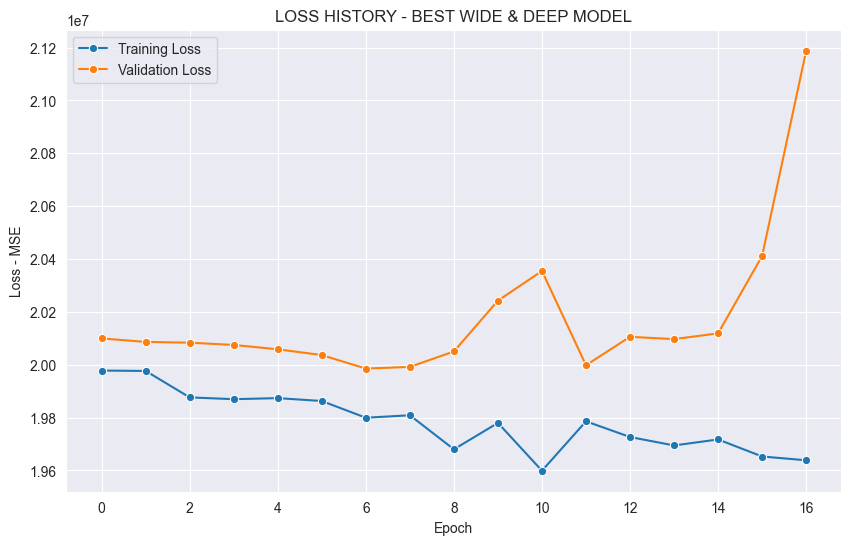

In [458]:
# plotting the loss history
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.lineplot(data = hist_main.history['loss'], label = 'Training Loss', marker = 'o')
sns.lineplot(data = hist_main.history['val_loss'], label = 'Validation Loss', marker = 'o')
plt.title('LOSS HISTORY - BEST WIDE & DEEP MODEL')
plt.xlabel('Epoch')
plt.ylabel('Loss - MSE')
plt.legend()
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.show()

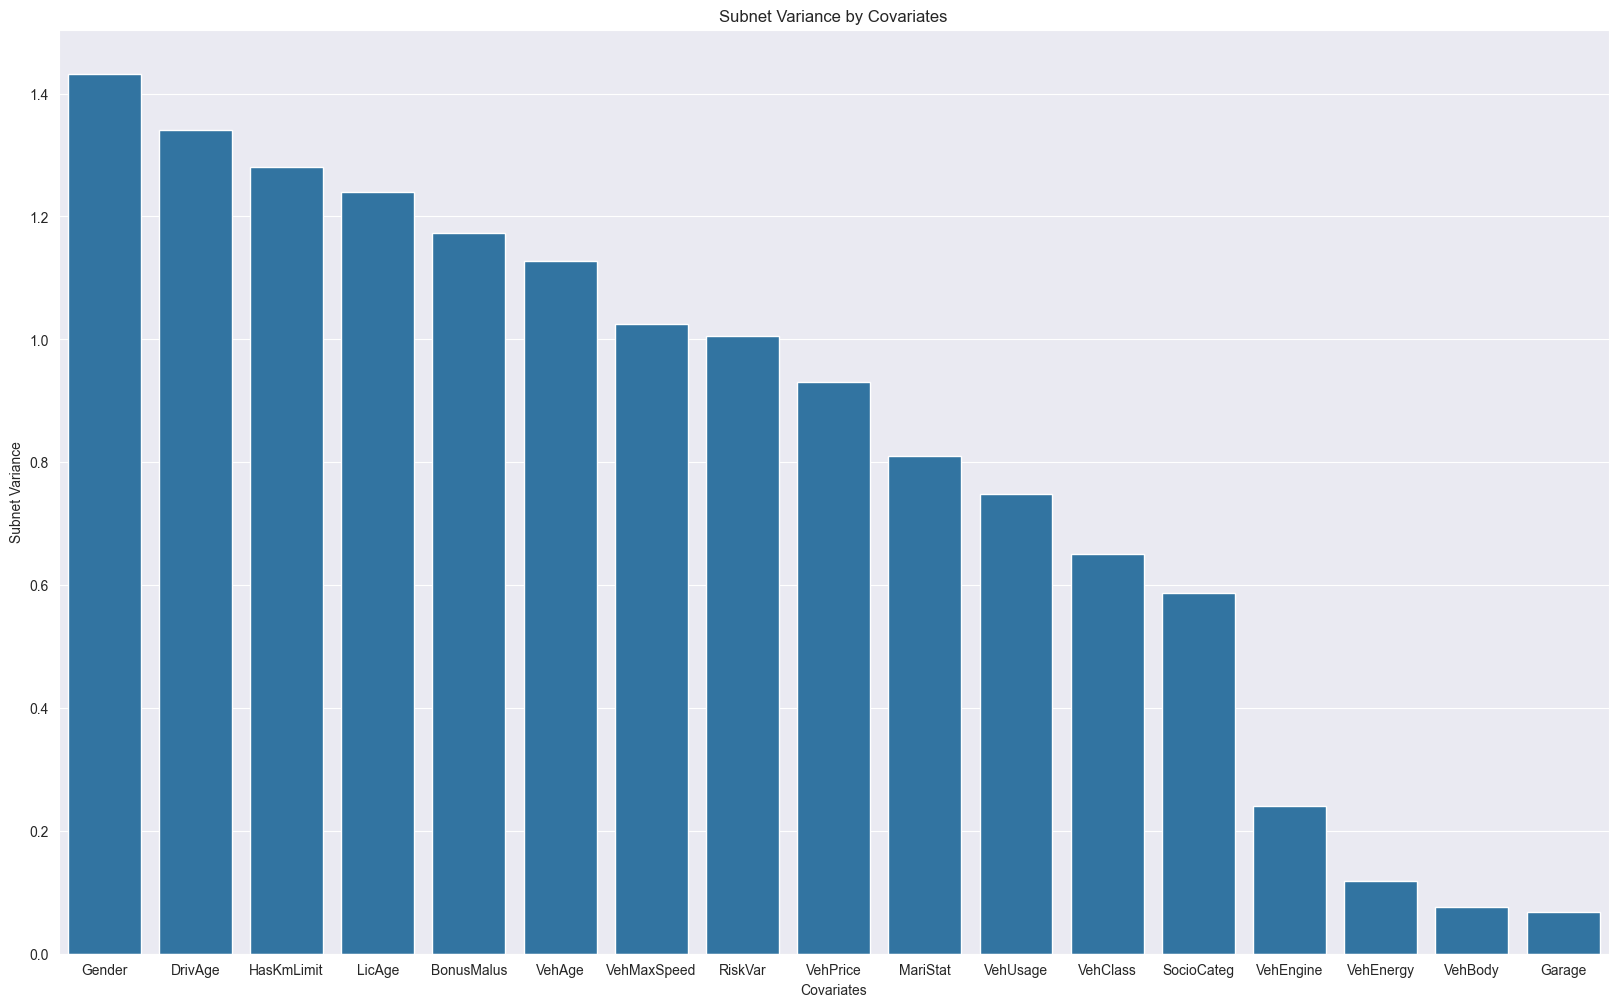

In [459]:
# -------------------------- quantify variable importance --------------------------

'''Source: https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer'''
subnet_output_layer = model_main.get_layer("subnet_output")  # Get the layer
subnet_output_function = K.function(model_main.inputs, [subnet_output_layer.output])  # create a function to produce the layer's values
subnet_output_values = subnet_output_function(X_train_split)[0] # get the subnetwork output

# get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:,i]))
covariates = [name for name in feature_names if name != "Exposure"]

# -------------------------- plot the variable importance --------------------------
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(x="Covariates", y="Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

In [460]:
# -------------------------- get the predictions of main effect --------------------------
'''these predictions will then be used to calculate the residuals to select pairwise interaction effect'''

# split the data to facilitate NAM
train_main_split = []
test_main_split = []
for i in range(len(feature_names)):
    train_main_split.append(train[:, i])
    test_main_split.append(test[:, i])

# make predictions
y_train_main_pred = model_main.predict(train_main_split)
y_test_main_pred = model_main.predict(test_main_split)

21/21 [==============================] - 0s 1ms/step


In [461]:
# -------------------------- data preparation --------------------------
unimportant_vars = ["VehEngine", "VehEnergy", "VehBody", "Garage"] # unimportant variables
train_df = pd.DataFrame(train, columns = feature_names)
test_df = pd.DataFrame(test, columns = feature_names)
train_NAM = train_df.drop(columns = unimportant_vars).reset_index(drop = True)
test_NAM = test_df.drop(columns = unimportant_vars).reset_index(drop = True)
y_train_res = y_train - y_train_main_pred # interaction effects will be fitted on the residuals of the model in the previous step
y_test_res = y_test - y_test_main_pred # interaction effects will be fitted on the residuals of the model in the previous step
train_NAM.head()

,Exposure,SocioCateg,VehClass,VehUsage,Gender,MariStat,HasKmLimit,LicAge,VehAge,DrivAge,BonusMalus,VehPrice,VehMaxSpeed,RiskVar
0,0.486,10.0,1.0,0.0,0.0,1.0,1.0,0.196063,-0.839662,1.390444,-0.816187,-1.521354,-2.012937,0.573678
1,0.833,7.0,1.0,1.0,0.0,0.0,0.0,0.089113,-1.281046,0.196544,-0.816187,-1.278492,-0.602621,0.365438
2,0.528,0.0,1.0,2.0,0.0,1.0,0.0,1.146727,-0.839662,1.324116,-0.816187,-0.792767,-0.602621,-1.092245
3,0.625,7.0,2.0,0.0,0.0,0.0,0.0,-1.449774,-1.281046,-0.599388,1.490326,-0.064180,-0.132515,0.573678
4,0.916,3.0,4.0,2.0,0.0,1.0,0.0,0.897178,-1.281046,0.660839,0.670233,0.421544,0.337590,-1.092245


In [462]:
#-------------------------- identify the interaction effect to fit the model --------------------------
interaction_strength = {}
train_interaction = train_NAM.drop(columns = ["Exposure"]).reset_index(drop = True)
test_interaction = test_NAM.drop(columns = ["Exposure"]).reset_index(drop = True)
columns = train_interaction.columns

# Iterate over all combinations of two columns
for col1, col2 in itertools.combinations(columns, 2):
    # Create a new DataFrame with the pair of columns
    X_train_pair = train_interaction[[col1, col2]]
    X_test_pair = test_interaction[[col1, col2]]
    
    # Fit a shallow decision tree
    tree = DecisionTreeRegressor(max_depth = 2)
    tree.fit(X_train_pair, y_train_res)
    
    # Predict on the test set
    y_test_res_pred = tree.predict(X_test_pair)
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test_res.values, y_test_res_pred)
    rmse = np.sqrt(mse)
    
    # Store the result in the dictionary
    interaction_strength[f"{col1} & {col2}"] = rmse

# Create a DataFrame from the dictionary and sort it
interaction_df = pd.DataFrame(list(interaction_strength.items()), columns=['Interaction', 'RMSE'])
interaction_df = interaction_df.sort_values(by = 'RMSE', ascending = False)

# Display the sorted DataFrame
interaction_df.reset_index(drop=True, inplace=True)
interaction_df

,Interaction,RMSE
0,DrivAge & RiskVar,4886.948056
1,VehAge & VehMaxSpeed,4868.851341
2,SocioCateg & HasKmLimit,4865.640790
3,SocioCateg & VehAge,4863.913000
4,SocioCateg & VehPrice,4863.341325
...,...,...
73,VehClass & DrivAge,4812.802084
74,HasKmLimit & DrivAge,4812.802084
75,DrivAge & VehPrice,4812.802084
76,Gender & DrivAge,4812.802084


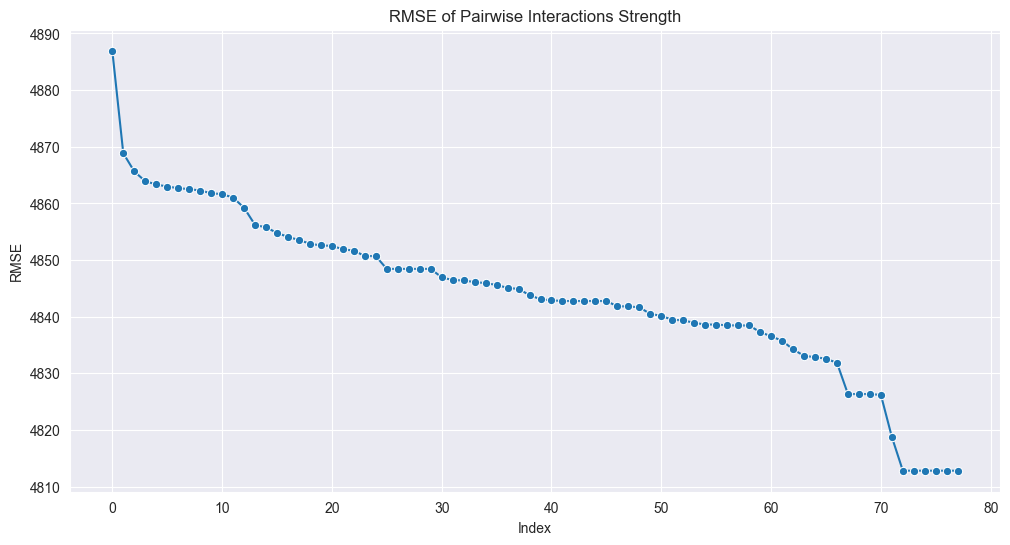

In [463]:
# Generate the line plot using Seaborn
plt.figure(figsize = (12, 6))
sns.lineplot(data = interaction_df, x = interaction_df.index, y = 'RMSE', marker = 'o')
plt.xlabel('Index')
plt.ylabel('RMSE')
plt.title('RMSE of Pairwise Interactions Strength')
plt.grid(True)
plt.show()

In [464]:
# we get the top 10 pairs based on the above graph
top_10_interactions = interaction_df.head(10) # extract top 10 interactions
pairwise_interactions = [tuple(interaction.split(' & ')) for interaction in top_10_interactions['Interaction']]
pairwise_interactions

[('DrivAge', 'RiskVar'),
 ('VehAge', 'VehMaxSpeed'),
 ('SocioCateg', 'HasKmLimit'),
 ('SocioCateg', 'VehAge'),
 ('SocioCateg', 'VehPrice'),
 ('SocioCateg', 'MariStat'),
 ('Gender', 'VehMaxSpeed'),
 ('SocioCateg', 'VehClass'),
 ('VehClass', 'VehMaxSpeed'),
 ('HasKmLimit', 'VehMaxSpeed')]

In [465]:
# -------------------------- define specialized layers & constraints for MIN-MAX network --------------------------

'''create a specialized MIN layer'''
class MinLayer(Layer):
    def __init__(self, **kwargs):
        super(MinLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return K.min(inputs, axis=-1, keepdims=True)

'''create a specialized MAX layer'''
class MaxLayer(Layer):
    def __init__(self, **kwargs):
        super(MaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return K.max(inputs, axis=-1, keepdims=True)

# Custom constraints
'''Adapted from: https://keras.io/api/layers/constraints/ '''
class PositiveConstraint(Constraint):
    def __call__(self, w):
        return K.maximum(w, 0.0)

class NegativeConstraint(Constraint):
    def __call__(self, w):
        return K.minimum(w, 0.0)


# -------------------------- define the architecture for MIN-MAX network --------------------------
def create_MINMAX(input_layer, num_groups, neurons_per_group, activation, monotonicity_list):
    
    """Examples of monotonicity list: ["positive", "negative", "none"]. This example shows an input of size 3,
    where all weights connecting the first input neuron with the dense layer should always be positive; negative for
    the second neuron and nothing is applied for the third neuron """

    # Collect min values from each group
    min_layers = []
    for i in range(num_groups):
        if monotonicity_list[i] == "positive":
            constraint = PositiveConstraint()
        elif monotonicity_list[i] == "negative":
            constraint = NegativeConstraint()
        else:
            constraint = None
        
        dense_layer = Dense(neurons_per_group, activation = activation, kernel_constraint = constraint)(input_layer)
        min_layer = MinLayer()(dense_layer)
        min_layers.append(min_layer)
    
    # Concatenate the min values
    concatenated_min_values = Concatenate(axis = -1)(min_layers)
    
    # Compute the max of concatenated min values
    output_layer = MaxLayer()(concatenated_min_values)
    
    # Create the model
    model = Model(inputs = input_layer, outputs = output_layer)
    return model

In [466]:
# -------------------------- data preparation --------------------------

# monotonicity list
monotonicity = {"BonusMalus": "positive"}

# list of embedding and binary vars
embedding_vars_filtered = ["SocioCateg", "VehClass", "VehUsage"] # categorical variables with many levels that require embedding
feature_names_filtered = [var for var in feature_names if var not in unimportant_vars]


# -------------------------- define the complete NAM --------------------------
def build_NAM(hp):

    # list of layers
    inputs = []  # Store input layers
    sub_outputs = []  # Outputs from each subnet
    interactions_input = {} # used to store layers as input for pairwise interaction effect subnet

    # hyperparameters
    num_layers_main = hp.Int('num_layers', 2, 4) # number of hidden layers for main effects' subnets
    num_layers_interaction = hp.Int('num_layers', 2, 8, step = 2) # number of hidden layers for interaction effects' subnets
    units_main = hp.Int('units_main', 5, 15, step = 2) # number of units per layer for main effect
    units_interaction = hp.Int('units_interaction', 15, 30, step = 5) # number of units per layer for interaction effect
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step = 0.1)
    embedding_dim = hp.Int("embedding_dimension", 2, 4) # embedding dimension for categorical variables
    MINMAX_groups_main = hp.Int('num_layers', 3, 8) # number of groups of MINMAX network for main effect
    MINMAX_groups_interaction = hp.Int('num_layers', 5, 10) # number of groups of MINMAX network for interaction effect
    MINMAX_neurons_main = hp.Int('num_layers', 3, 8) # number of neurons per group of MINMAX network for main effect
    MINMAX_neurons_interaction = hp.Int('num_layers', 5, 10) # number of neurons per group of MINMAX network for interaction effect
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate for optimizer

    # main effect
    for name in feature_names_filtered:
        
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)
        interactions_input[name] = input_layer
        
        # subnetwork
        if name == "Exposure":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in embedding_vars_filtered:
            # categorical variables will pass through an embedding layer
            embed_layer = Embedding(input_dim = claim[name].nunique(), 
                        output_dim = embedding_dim,
                        name = f"embed_{name}")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
            interactions_input[name] = embed_layer_reshape # used for pairwise interaction effect
            subnet = create_subnet(num_layers_main, units_main, activation, dropout_rate)
            sub_output = subnet(embed_layer_reshape)
            sub_outputs.append(sub_output)
        else:
            if name in monotonicity:
                subnet = create_MINMAX(input_layer, num_groups = MINMAX_groups_main, 
                                    neurons_per_group = MINMAX_neurons_main, activation = activation, 
                                    monotonicity_list = monotonicity[name])
            else:
                subnet = create_subnet(num_layers_main, units_main, activation, dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)


    # pairwise interactions
    for (var1, var2) in pairwise_interactions:

        # get the relevant input layers
        input_layer1 = interactions_input[var1]
        input_layer2 = interactions_input[var2]

        # concatenate
        pairwise_input = Concatenate()([input_layer1, input_layer2])
        
        # create the monotonicity list
        monotonicity_list = []
        if var1 in monotonicity:
            monotonicity_list.append(monotonicity[var1])
        else:
            for _ in range(input_layer1.shape[1]):
                monotonicity_list.append("none")
        if var2 in monotonicity:
            monotonicity_list.append(monotonicity[var2])
        else:
            for _ in range(input_layer2.shape[1]):
                monotonicity_list.append("none")

        # subnetworks
        if var1 in monotonicity or var2 in monotonicity:
            pairwise_subnet = create_MINMAX(pairwise_input, num_groups = MINMAX_groups_interaction, 
                                            neurons_per_group = MINMAX_neurons_interaction, 
                                            activation = activation, 
                                            monotonicity_list = monotonicity_list)
        else:
            pairwise_subnet = create_subnet(num_layers_interaction, units_interaction, activation, dropout_rate)
        pairwise_output = pairwise_subnet(pairwise_input)
        sub_outputs.append(pairwise_output)

    # combine subnets' outputs
    subnets = Concatenate(name = f"subnet_output")(sub_outputs)
    output_layer = Dense(1, activation = "exponential")(subnets)

    # multiply output with exposure
    final_output = Multiply()([exposure_input, output_layer])
    model = Model(inputs = inputs, outputs = final_output)

    #compile and return model
    model.compile(optimizer = Adam(learning_rate = lr), loss = 'mean_squared_error', 
                  metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    return model

In [467]:
# -------------------------- compile and fit the model --------------------------

# hyperparameter tuning
tuner_NAM = kt.RandomSearch(
    build_NAM,
    objective = 'val_loss',
    max_trials = 20,  # Increased trials due to additional hyperparameters
    directory = "hyperparameter_tuning_NAM_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True)

# training data need to be split into different arrays, each correponds to input for a particular subnet
X_train_NAM_split = []
for i in range(len(feature_names_filtered)):
    X_train_NAM_split.append(np.array(train_NAM)[:, i])

# search for the best model
tuner_NAM.search(X_train_NAM_split, y_train,
            epochs = 500,
            validation_split = 0.25,
            callbacks = [es])

# get the best model
model_NAM = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(1)

Reloading Tuner from hyperparameter_tuning_NAM_freMPL1/untitled_project/tuner0.json
Results summary
Results in hyperparameter_tuning_NAM_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 10 summary
Hyperparameters:
num_layers: 2
units_main: 11
units_interaction: 15
activation: relu
dropout_rate: 0.2
embedding_dimension: 4
learning_rate: 0.003373201432675782
Score: 17044012.0


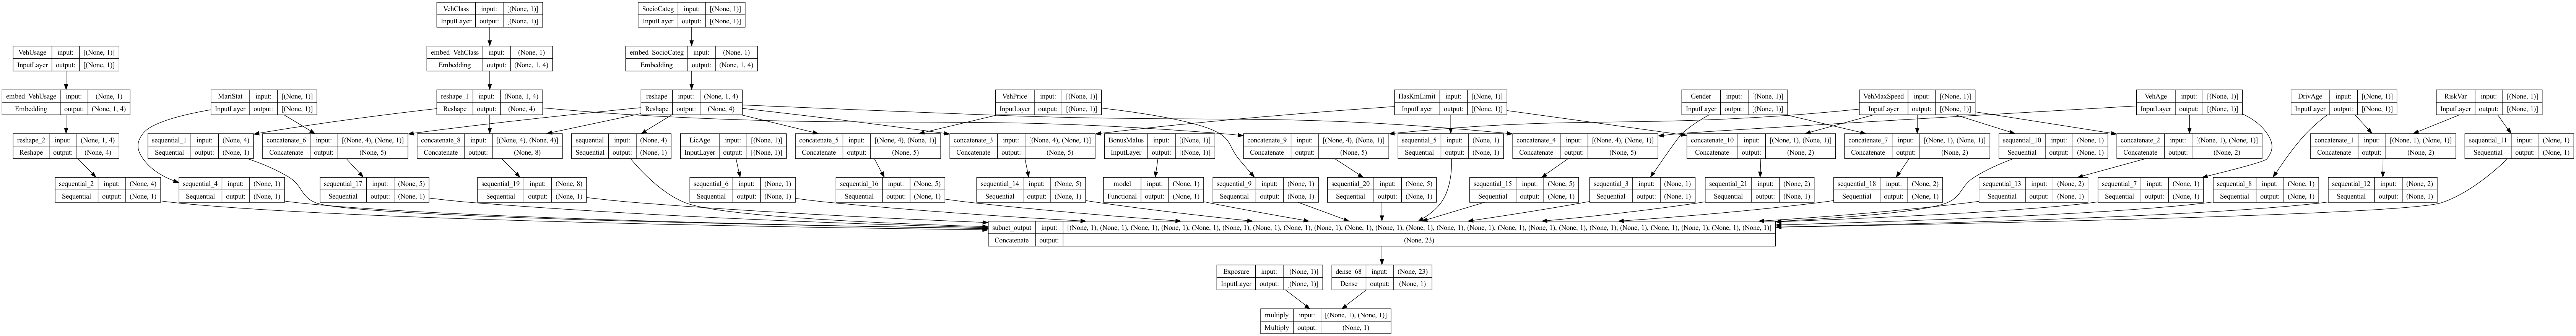

In [468]:
plot_model(model_NAM, show_layer_names = True, show_shapes = True)

In [469]:
#-------------------------- evaluate on testing data --------------------------

# split testing data into different sets
X_test_NAM_split = []
for i in range(len(feature_names_filtered)):
    X_test_NAM_split.append(np.array(test_NAM)[:, i])

# evaluation
_, nam_rmse, nam_mae = model_NAM.evaluate(X_test_NAM_split, y_test)

21/21 [==============================] - 1s 2ms/step - loss: 25056114.0000 - root_mean_squared_error: 5005.6084 - mean_absolute_error: 2159.8186


In [470]:
############################ 3. GLM ############################

# -------------------------- train-test split --------------------------
'we will drop LicAge and VehMaxSpeed from the training data due to multicollinearity issue'
X_train_GLM = X_train.drop(columns = ["LicAge", "VehMaxSpeed"]).reset_index(drop = True)
X_test_GLM = X_test.drop(columns = ["LicAge", "VehMaxSpeed"]).reset_index(drop = True)

# -------------------------- apply encoding --------------------------
# define transformer
ct_GLM = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OneHotEncoder(drop = 'first'), nominal_vars),
    remainder = "passthrough",
    verbose_feature_names_out = False
)

# fit & transform
train_GLM = ct_GLM.fit_transform(X_train_GLM)
test_GLM = ct_GLM.transform(X_test_GLM)

# get the exposure
expo_train = train_GLM[:, 0]
expo_test = test_GLM[:, 0]

# remove exposure from data
train_GLM = train_GLM[:,1:]
test_GLM = test_GLM[:,1:]

# add intercept terms
train_GLM = sm.add_constant(train_GLM)
test_GLM = sm.add_constant(test_GLM)

In [471]:
# -------------------------- fit a GLM with Gaussian distribution --------------------------
model = sm.GLM(y_train, train_GLM, family = sm.families.Gamma(sm.families.links.log()), offset = np.log(expo_train))
model_GLM = model.fit()

# get model summary
print(model_GLM.summary())

/Users/tupho/miniconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                 2611
Model:                            GLM   Df Residuals:                     2568
Model Family:                   Gamma   Df Model:                           42
Link Function:                    log   Scale:                          5.2516
Method:                          IRLS   Log-Likelihood:                -23835.
Date:                Wed, 24 Jul 2024   Deviance:                       5684.8
Time:                        03:20:58   Pearson chi2:                 1.35e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.04846
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8378      1.028      7.621      0.0

In [472]:
# -------------------------- evaluate model performance --------------------------
GLM_pred = model_GLM.predict(test_GLM, offset = np.log(expo_test))
GLM_rmse = np.sqrt(mean_squared_error(y_test, GLM_pred))
GLM_mae = mae(y_test, GLM_pred)
print(GLM_rmse)
print(GLM_mae)

5512.6424186990025
3336.882267759716


In [473]:
############################ 4. ARTIFICIAL NEURAL NETWORKS ############################

#-------------------------- define the neural network architecture--------------------------
# separate multi-level categorical columns from other columns
train_cat = []
val_cat = []
test_cat = []
cat_index = []
for i in range(len(embedding_vars)):
    index = np.where(feature_names == embedding_vars[i])[0][0]
    train_cat.append(train[:,index])
    test_cat.append(test[:,index])
    cat_index.append(index)

# exposure
expo_train = train[:,0]
expo_test = test[:,0]
                    
# drop exposure and nominal categorical columns
train_others = np.delete(train, [0] + cat_index, axis = 1)
test_others = np.delete(test, [0] + cat_index, axis = 1)


#-------------------------- define the neural network architecture--------------------------
def build_NN(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 3, 8, step = 1) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons_first_hidden', 200, 800, step = 10) # number of neurons in the first hidden layers
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0.2, max_value = 0.5, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate
    embedding_dim = hp.Int('embedding_dim', 2, 5, step = 1) # dimension of the embedding layer
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'swish', 'gelu'])

    # embedding layers for nominal categorical variables with > 4 levels
    cat_inputs = [] # input layers for categorical features
    embedding_layers = [] # embedding layers
    for cat_column in embedding_vars:

        # input layers
        cat_input = Input(shape = (1,), name = f"input_{cat_column}") 
        cat_inputs.append(cat_input)

        # embedding layers
        embed_layer = Embedding(input_dim = claim[cat_column].nunique(), 
                                output_dim = embedding_dim, 
                                name = f"embed_{cat_column}")(cat_input)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,), name = f"reshape_{cat_column}")(embed_layer)
        embedding_layers.append(embed_layer_reshape)

    # combine embedding with other inputs  
    other_inputs = Input(shape = train_others.shape[1:])
    inputs = Concatenate(name = "combined_input")(embedding_layers + [other_inputs])


    # dense layers
    x = inputs
    for i in range(num_layers):
        num_units = num_neurons - i*int(num_neurons/num_layers)
        x = Dense(units = num_units, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    
    # skip connection
    concat = Concatenate()([x,inputs])

    # output layer with exposure
    lambda_ = Dense(1, "exponential")(concat)
    exposure_layer = Input(shape = (1,), name = "exposure") # exposure
    output = Multiply()([lambda_, exposure_layer]) # adjust the predicted claim by the exposure

    # model
    model = Model([exposure_layer] + [other_inputs] + cat_inputs, output)
    
    # build model
    model.compile(optimizer = Adam(learning_rate = lr),
            loss = "mean_squared_error",
            metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [474]:
# -------------------------- tune and fit the model --------------------------

# tuner
tuner_NN = kt.RandomSearch(
    build_NN,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_tuning_NN_freMPL1",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_NN.search([expo_train, train_others, train_cat], y_train,
        epochs = 1_000,
        validation_split = 0.25,
        callbacks = [es])

# get the best model
model_NN = tuner_NN.get_best_models()[0]
tuner_NN.results_summary(1)

Trial 20 Complete [00h 00m 07s]
val_loss: 20101714.0

Best val_loss So Far: 17149966.0
Total elapsed time: 00h 02m 03s
Results summary
Results in hyperparameter_tuning_NN_freMPL1/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
num_dense_layers: 4
num_neurons_first_hidden: 670
dropout_rate: 0.2
learning_rate: 0.00019601303117356097
embedding_dim: 3
activation: gelu
Score: 17149966.0


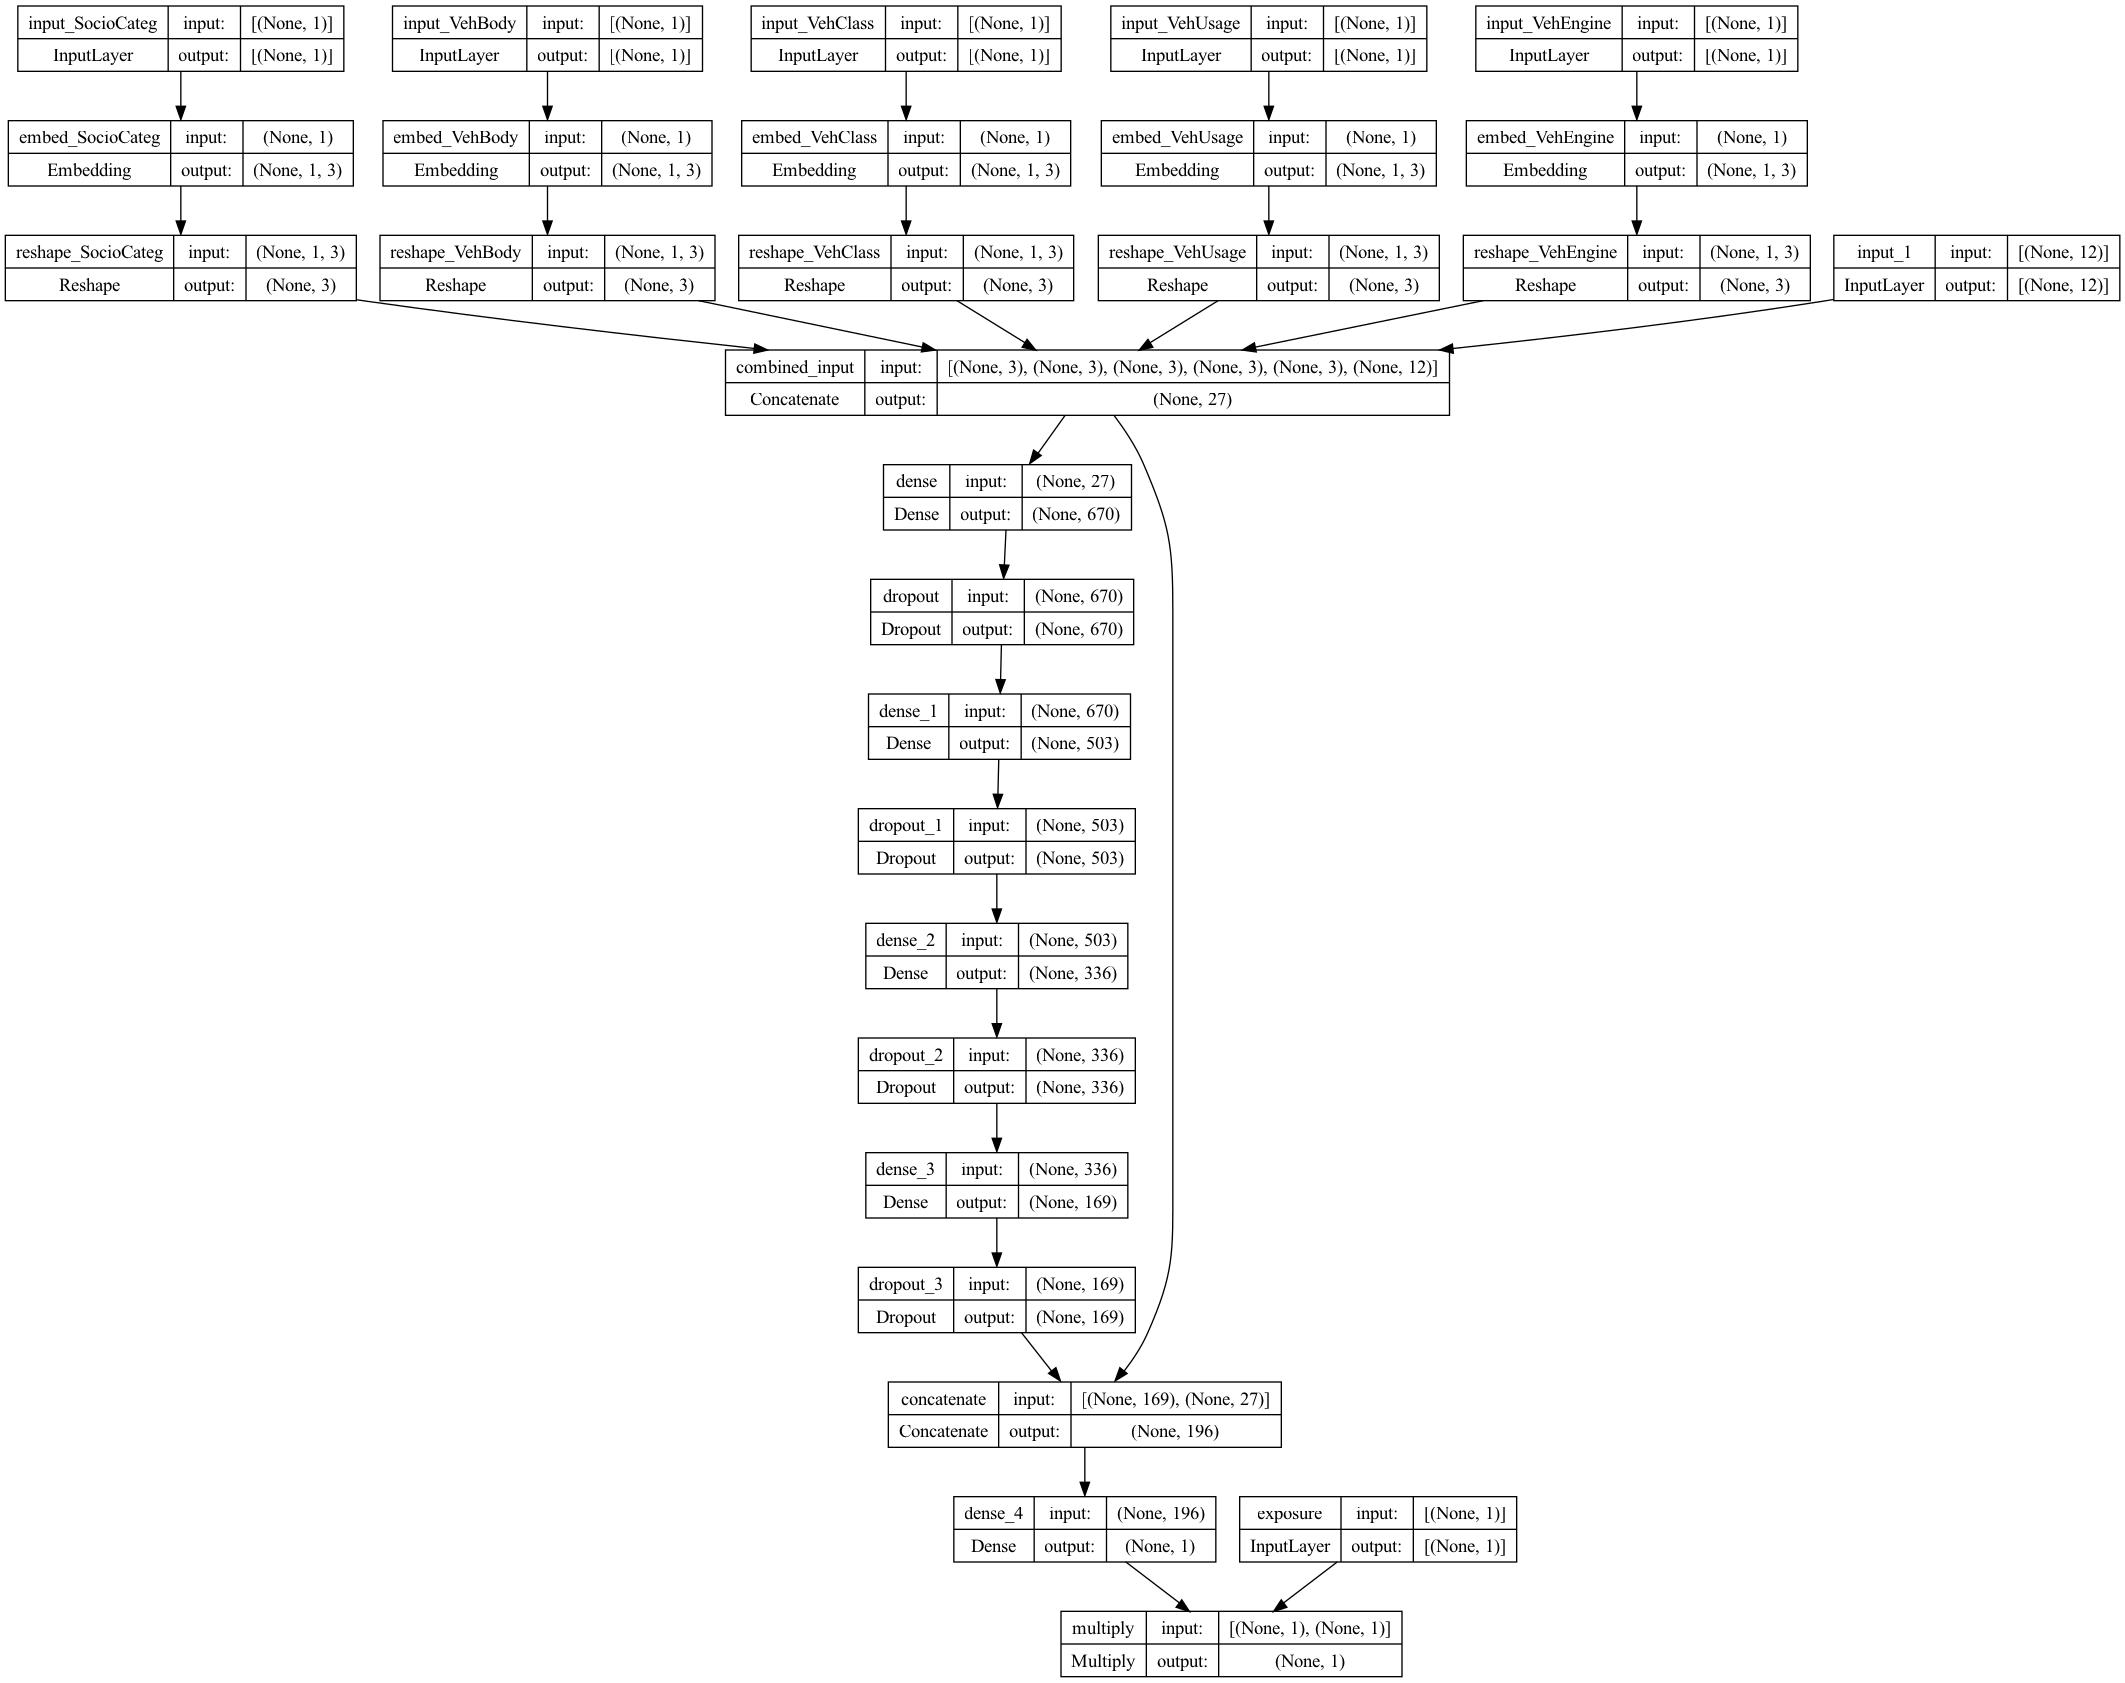

In [475]:
#-------------------------- plot model --------------------------
plot_model(model_NN, show_layer_names = True, show_shapes = True)

In [476]:
#-------------------------- evaluate on test set --------------------------
_, nn_rmse, nn_mae = model_NN.evaluate([expo_test, test_others, test_cat], y_test)

21/21 [==============================] - 0s 1ms/step - loss: 25149350.0000 - root_mean_squared_error: 5014.9126 - mean_absolute_error: 2131.0942


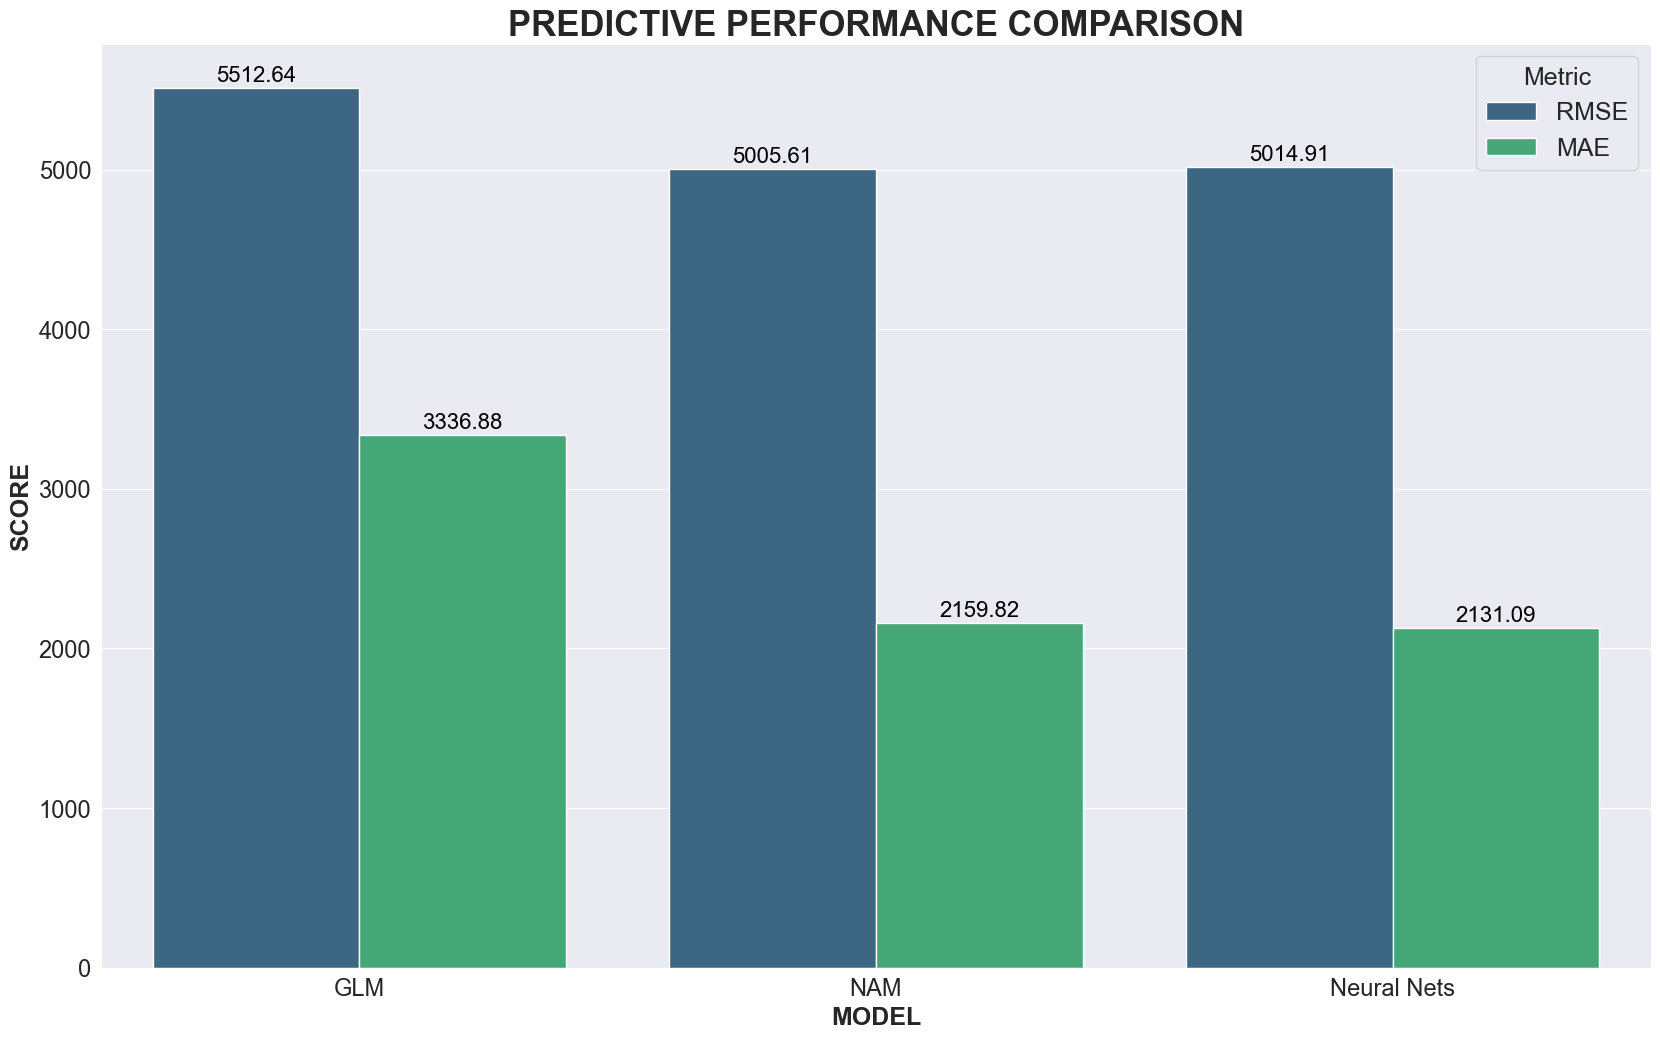

In [478]:
############################ 5. COMPARISON ############################

# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM', 'GLM', 'NAM', 'NAM', 'Neural Nets', 'Neural Nets'],
    'Metric': ['RMSE', 'MAE', 'RMSE', 'MAE', 'RMSE', 'MAE'],
    'Value': [GLM_rmse, GLM_mae, nam_rmse, nam_mae, nn_rmse, nn_mae]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (20, 12))
barplot = sns.barplot(x = 'Model', y = 'Value', hue = 'Metric', data = df_performance, palette = 'viridis')


'''AI: the code below is adapted from an answer given by ChatGPT. This is declared in the AI Appendix'''
# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.2f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 16, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON', fontsize = 25, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 18, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 18, fontweight = 'bold')
barplot.legend(title = 'Metric', fontsize = 18, title_fontsize = 18)

# size of x-label
barplot.tick_params(labelsize = 17)

# Show the plot
plt.show()